In [8]:
from qat.lang.AQASM import Program, RY, RX, RZ, RY, CNOT
import numpy as np
from qat.qpus import get_default_qpu
from sklearn.neural_network import MLPRegressor
#from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [9]:
#trotterisation of heisenber interaction between qubit pairs
def heisenberg_pair(pr, q1, q2, Jdt):
    # XX
    pr.apply(CNOT, q1, q2)
    pr.apply(RX(-2*Jdt), q2)
    pr.apply(CNOT, q1, q2)
    # YY
    pr.apply(RY(np.pi/2), q1)
    pr.apply(RY(np.pi/2), q2)
    pr.apply(CNOT, q1, q2)
    pr.apply(RX(-2*Jdt), q2)
    pr.apply(CNOT, q1, q2)
    pr.apply(RY(-np.pi/2), q1)
    pr.apply(RY(-np.pi/2), q2)
    # ZZ
    pr.apply(CNOT, q1, q2)
    pr.apply(RZ(-2*Jdt), q2)
    pr.apply(CNOT, q1, q2)

#nearest neighbour heisenberg between all block_qubits likely data + memory qubits
def multi_qubit_heisenberg_block(pr, block_qubits, J, dt, n_steps):
    """
    Applies n_steps of Heisenberg Trotterized evolution on ALL pairs in block_qubits
    """
    for _ in range(n_steps):
        for i in range(len(block_qubits)):
            for j in range(i+1, len(block_qubits)):
                heisenberg_pair(pr, block_qubits[i], block_qubits[j], J*dt)


In [10]:
#defining the reservoir with data interactions
def reservoir_with_data_interactions(data_vec, num_memory=2, shots=1024, J=1.0, dt=0.1, n_steps=1):
    from qat.qpus import PyLinalg
    T = len(data_vec)
    total_qb = T + num_memory
    pr = Program()
    q = pr.qalloc(total_qb)
    mem_idxs = [T + i for i in range(num_memory)]

    for t, x_t in enumerate(data_vec):
        # Angle encoding
        pr.apply(RY((np.pi/2)*(x_t + 1)), q[t])

        # Form interaction block: all data qubits up to t, plus all memory qubits
        active_data = [q[i] for i in range(t+1)]
        mem_qubits = [q[m] for m in mem_idxs]
        block_qubits = active_data + mem_qubits

        # Apply Trotterized Heisenberg to all pairs in block
        multi_qubit_heisenberg_block(pr, block_qubits, J, dt, n_steps)

    # Measurement: all data qubits
    pr.measure([q[i] for i in range(T)])
    circuit = pr.to_circ()
    qpu = get_default_qpu()
    job = circuit.to_job(nbshots=shots)
    result = qpu.submit(job)
    return result


In [11]:
def reservoir_with_qubit_reuse(data_vec, num_memory=2, shots=1024, J=1.0, dt=0.1, n_steps=1):
    from qat.lang.AQASM import Program, RY
    from qat.qpus import get_default_qpu

    T = len(data_vec)
    pr = Program()
    q_data = pr.qalloc(1)
    q_mem = pr.qalloc(num_memory)
    cbits = pr.calloc(T)  # One classical bit per timestep

    for t, x_t in enumerate(data_vec):
        pr.reset([q_data[0]])
        pr.apply(RY((np.pi/2)*(x_t + 1)), q_data[0])
        block_qubits = [q_data[0]] + [q_mem[m] for m in range(num_memory)]
        multi_qubit_heisenberg_block(pr, block_qubits, J, dt, n_steps)
        pr.measure(q_data[0], cbits[t])  # store this step's result in cbits[t]

    circuit = pr.to_circ()
    qpu = get_default_qpu()
    job = circuit.to_job(nbshots=shots)
    result = qpu.submit(job)
    return result

In [12]:
#postprocess reservoir results to extract <sigma_z> for each data qubit at final time step
def extract_sigmaz(result, n_data):
    # Arrays for sum of probability * value for each bit
    bit1_prob = np.zeros(n_data)
    total_prob = 0.0

    for sample in result.raw_data:
        cbits = sample.intermediate_measurements[-1].cbits if sample.intermediate_measurements else None
        prob = sample.probability
        if cbits is None:
            continue
        total_prob += prob
        for idx in range(n_data):
            if cbits[idx] == 1:
                bit1_prob[idx] += prob
    # Expectation value <σz> = 1 - 2P(1) for each qubit/time step
    sigmaz = 1 - 2*bit1_prob / total_prob if total_prob else np.ones(n_data)
    return sigmaz

In [13]:
def extract_sigmaz_reset(result, n_steps):
    """
    Compute <sigma_z> per timestep from myQLM reservoir output.
    Args:
        result: myQLM Result object (as provided)
        n_steps: number of timesteps (number of intermediate_measurements per Sample)
    Returns:
        np.ndarray: shape (n_steps,), <sigma_z> for each time step
    """
    bit1_prob = np.zeros(n_steps)
    total_prob = 0.0

    # Loop over all shots/samples
    for sample in result.raw_data:
        prob = sample.probability if hasattr(sample, 'probability') else sample['probability']
        total_prob += prob
        # Each sample has a list intermediate_measurements, length n_steps
        # For each time step t, get measured classical bit value (cbits[0])
        for t in range(n_steps):
            int_meas = sample.intermediate_measurements[t]
            cbit_val = int_meas.cbits[0] if hasattr(int_meas, 'cbits') else int_meas['cbits'][0]
            # Accumulate probability for '1' outcome
            if cbit_val == 1:
                bit1_prob[t] += prob
    # Convert to <sigma_z> = 1 - 2*P(1) for each time step
    sigmaz = 1 - 2 * (bit1_prob / total_prob) if total_prob else np.ones(n_steps)
    return sigmaz


In [14]:
#lagged features for training over all time steps
def make_lagged_features(features, targets, window):
    """ Return X, y using past `window` features to predict next target. """
    X, y = [], []
    for i in range(window, len(features)):
        # X is a vector of window values: [x_{i-window}, ..., x_{i-1}]
        X.append(features[i-window:i])
        y.append(targets[i])  # true value at time step i
    return np.array(X), np.array(y)

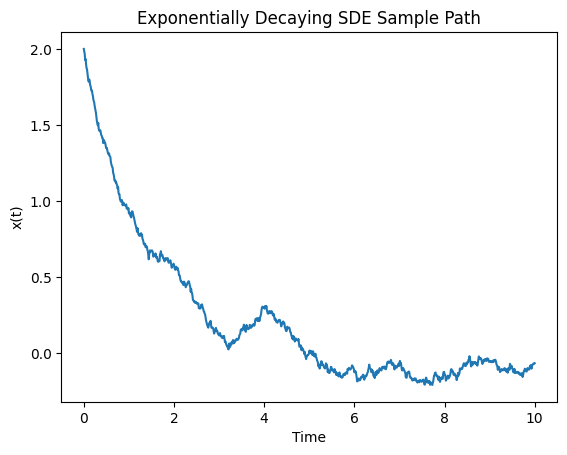

In [15]:
#input data generation here -- example stochastic exponential decay SDE
def exp_decay_sde(a=0.7, sigma=0.12, x0=2.0, dt=0.01, T=10.0, seed=2):
    """
    Simulate an exponentially decaying SDE:
    dx = -a*x*dt + sigma*dW
    Returns (t, x) arrays.
    """
    np.random.seed(seed)
    N = int(T / dt)
    t = np.linspace(0, T, N+1)
    x = np.zeros(N+1)
    x[0] = x0
    for i in range(N):
        dw = np.random.normal(0, np.sqrt(dt))
        x[i+1] = x[i] - a * x[i] * dt + sigma * dw
    return t, x

# Example usage
t, x = exp_decay_sde()
plt.plot(t, x)
plt.title("Exponentially Decaying SDE Sample Path")
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.show()


In [16]:
raw_features = reservoir_with_qubit_reuse(x)

c:\Users\cqtv201\AppData\Local\anaconda3\envs\qai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


QPUException: QPUException(code=None, modulename=None, message='KeyboardInterrupt: ()', file=None, line=None)

In [ ]:
ref_features = extract_sigmaz_reset(raw_features, len(x))

In [ ]:
#lagged features and next datapoint for training
#window for the making dataset per time step e..g. 10
X, y = make_lagged_features(ref_features, x, 10)

In [ ]:
# Split into train/test (e.g., last 20% for test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# MLP regressor (simple NN)
mlp = MLPRegressor(hidden_layer_sizes=(1,), max_iter=500, random_state=0)
mlp.fit(X_train, y_train)


MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=0)

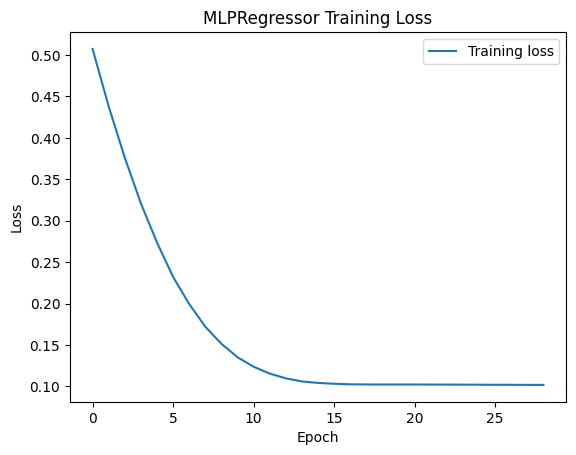

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mlp.loss_curve_, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLPRegressor Training Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
# Assuming you have a trained model:
y_pred = mlp.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE:  {mae:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MSE:  {mse:.6f}")
print(f"Test R^2:  {r2:.4f}")

Test MAE:  0.278920
Test RMSE: 0.286284
Test MSE:  0.081959
Test R^2:  -57.8353
